In [1]:
# for interactive plots
#%matplotlib notebook

# else
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12.0, 8.0)
mpl.rcParams['font.size'] = 12
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.subplot.bottom'] = .1 

from mpl_toolkits.mplot3d import Axes3D # required for 3d plots
from matplotlib import cm # required for colors

import matplotlib.pyplot as plt
import time

import pymor.tools.random
pymor.tools.random._default_random_state = None

from IPython import get_ipython
ip = get_ipython()
if ip is not None:
    ip.run_line_magic('load_ext', 'pymor.discretizers.builtin.gui.jupyter')

In [2]:
import numpy as np
from pymor.basic import *

In [3]:
set_log_levels({'online_adaptive_lrbms': 'DEBUG',
                'OS2015_academic_problem': 'INFO',
                'local_thermalblock_problem': 'INFO',
                'senegal_proceedings_problem': 'INFO',
                'discretize_elliptic': 'INFO',
                'offline': 'INFO',
                'online_enrichment': 'INFO',
                'lrbms': 'INFO',
                'notebook': 'INFO'})
logger = getLogger('notebook.notebook')

In [4]:
domain = RectDomain(([-1,-1], [1,1]))
indicator_domain = ExpressionFunction(
    '(-2/3. <= x[..., 0]) * (x[..., 0] <= -1/3.) * (-2/3. <= x[..., 1]) * (x[..., 1] <= -1/3.) * 1. \
   + (-2/3. <= x[..., 0]) * (x[..., 0] <= -1/3.) *  (1/3. <= x[..., 1]) * (x[..., 1] <=  2/3.) * 1.', 
    dim_domain=2, shape_range=())
rest_of_domain = ConstantFunction(1, 2) - indicator_domain
f = ExpressionFunction('0.5*pi*pi*cos(0.5*pi*x[..., 0])*cos(0.5*pi*x[..., 1])', dim_domain=2, shape_range=())

parameters = {'diffusion': 2}
thetas = [ExpressionParameterFunctional('1.1 + sin(diffusion[0])*diffusion[1]', parameters,
                                       derivative_expressions={'diffusion': ['cos(diffusion[0])*diffusion[1]',
                                                                             'sin(diffusion[0])']}),
          ExpressionParameterFunctional('1.1 + sin(diffusion[1])', parameters,
                                       derivative_expressions={'diffusion': ['0',
                                                                             'cos(diffusion[1])']}),

                                       ]
diffusion = LincombFunction([rest_of_domain, indicator_domain], thetas)

In [5]:
problem = StationaryProblem(domain, f, diffusion)

In [6]:
fom, data = discretize_stationary_cg(problem, diameter=1/100)

output_functional = fom.rhs.H
output_functional = LincombOperator([fom.rhs.H],
                                    [ExpressionParameterFunctional('1 + 1/5 * diffusion[0] + 1/5 * diffusion[1]', parameters,
                                       derivative_expressions={'diffusion': ['1/10',
                                                                             '1/10']})])
fom = fom.with_(output_functional=output_functional)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

In [7]:
from pymor.discretizers.builtin.cg import InterpolationOperator

initial_guess = fom.parameters.parse([0.25, 0.5])

diff = InterpolationOperator(data['grid'], problem.diffusion).as_vector(initial_guess)
rhs = InterpolationOperator(data['grid'], problem.rhs).as_vector(initial_guess)

In [8]:
fom.visualize(diff)

Output()

In [9]:
fom.visualize(rhs)

Output()

In [10]:
parameter_space = fom.parameters.space(0, np.pi)

In [11]:
fom.parameters

Parameters({diffusion: 2})

In [12]:
def compute_value_matrix(f, x, y):
    f_of_x = np.zeros((len(x), len(y)))
    for ii in range(len(x)):
        for jj in range(len(y)):
            f_of_x[ii][jj] = f((x[ii], y[jj]))
    x, y = np.meshgrid(x, y)
    return x, y, f_of_x


def plot_3d_surface(f, x, y, alpha=1):
    X, Y = x, y
    cmaps = [plt.get_cmap(name) for name in ('Purples', 'Oranges', 'Blues')]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    if isinstance(f, (list, tuple)):
        for ii in range(len(f)):
            x, y, f_of_x = compute_value_matrix(f[ii], X, Y)
            ax.plot_surface(x, y, f_of_x, cmap=cmaps[ii%len(cmaps)],
                            linewidth=0, antialiased=False, alpha=alpha)
    else:
        x, y, f_of_x = compute_value_matrix(f, x, y)
        ax.plot_surface(x, y, f_of_x, cmap=cmaps[0],
                        linewidth=0, antialiased=False, alpha=alpha)
    ax.view_init(elev=27.7597402597, azim=-39.6370967742)
    ax.set_xlim3d([-0.10457963, 3.2961723])
    ax.set_ylim3d([-0.10457963, 3.29617229])
    #ax.set_zlim3d([ 1.21122592, 4.42022848])
    return ax


def addplot_xy_point_as_bar(ax, x, y, color='orange', z_range=None):
    ax.plot([y, y], [x, x], z_range if z_range else ax.get_zlim(), color)

In [13]:
logger.info('computing some reference quantities of interest ...')

training_set = parameter_space.sample_uniformly(25)
training_set_simple = [mu['diffusion'] for mu in training_set]

def fom_objective_functional(mu):
    # corresponds to J(u_mu) = F(mu) 
    return fom.output(mu).to_numpy()

#reference_quantities_of_interest = list()
#for mu in training_set:
#    reference_quantities_of_interest.append(reference_quantity_of_interest(mu))

logger.info('... done')

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

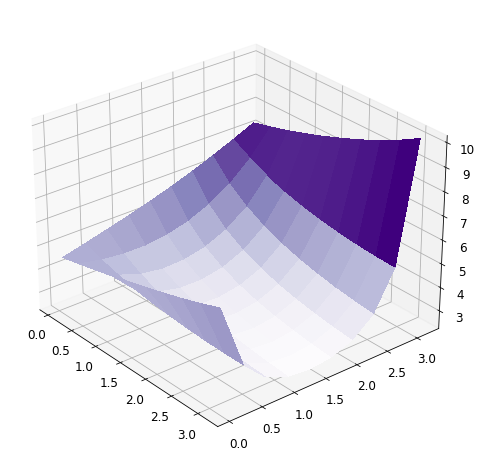

In [14]:
logger.info('plotting ...')

ranges = parameter_space.ranges['diffusion']
XX = np.linspace(ranges[0] + 0.05, ranges[1], 10)
YY = XX

plot_3d_surface(fom_objective_functional, XX, YY)

logger.info('... done')

In [15]:
logger.info('minimizing reference quantity of interest:')

reference_minimization_data = {'num_evals': 0,
                               'evaluations' : [],
                               'evaluation_points': []}

def record_results(function, data, mu):
    print('.', end='')
    QoI = function(mu)
    data['num_evals'] += 1
    # we need to make sure to copy the data, since the added mu will be changed inplace by minimize afterwards
    data['evaluation_points'].append([fom.parameters.parse(mu)['diffusion'][:][0], 
                                      fom.parameters.parse(mu)['diffusion'][:][1]])
    data['evaluations'].append(QoI[0])
    return QoI


def report(result, data):
    if (result.status != 0):
        logger.info(' failed!')
    else:
        logger.info(' succeded!')
        logger.info('  mu_min:    {}'.format(fom.parameters.parse(result.x)))
        logger.info('  QoI(mu_min): {}'.format(result.fun[0]))
        logger.info('  num iterations:     {}'.format(result.nit))
        logger.info('  num function calls: {}'.format(data['num_evals']))


def extended_report(data):
    for kk, vv in data.items():
        logger.info(kk)
        if isinstance(vv, (list, tuple)):
            for v in vv:
                logger.info('  {}'.format(v))
        else:
            logger.info('  {}'.format(vv))
        logger.info('')

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

In [22]:
from functools import partial
from scipy.optimize import minimize

tic = time.time()
result = minimize(partial(record_results, fom_objective_functional, reference_minimization_data),
                  initial_guess.to_numpy(),
                  method='L-BFGS-B', jac=False,
                  bounds=(ranges, ranges),
                  options={'ftol': 1e-10})
logger.info('this took {:.5f} seconds'.format(time.time()-tic))

.

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

............................................

In [23]:
report(result, reference_minimization_data)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

In [24]:
reference_minimizer = result.x
reference_minimum = result.fun[0]
reference_num_global_solves = reference_minimization_data['num_evals']

logger.info('reference_minimizer: mu = {}'.format(reference_minimizer))
logger.info('reference_minimum: {}'.format(reference_minimum))
logger.info('reference_num_global_solves: {}'.format(reference_num_global_solves))
logger.info('')

extended_report(reference_minimization_data)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

In [19]:
logger.info('plotting chosen points during minimization of reference quantity of interest ...')

reference_plot = plot_3d_surface(fom_objective_functional, XX, YY, alpha=0.5)

for mu in reference_minimization_data['evaluation_points']:
    addplot_xy_point_as_bar(reference_plot, mu[0], mu[1])

logger.info('... done')

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/Tii/Projects/pymor/venv3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-02a5e406982f>", line 3, in <module>
    reference_plot = plot_3d_surface(fom_objective_functional, XX, YY, alpha=0.5)
  File "<ipython-input-12-e1870dde0baf>", line 21, in plot_3d_surface
    x, y, f_of_x = compute_value_matrix(f, x, y)
  File "<ipython-input-12-e1870dde0baf>", line 5, in compute_value_matrix
    f_of_x[ii][jj] = f((x[ii], y[jj]))
  File "<ipython-input-13-021397e06d9c>", line 8, in fom_objective_functional
    return fom.output(mu).to_numpy()
  File "/Users/Tii/Projects/pymor/src/pymor/models/interface.py", line 91, in output
    return self.solve(mu=mu, return_output=True, **kwargs)[1]
  File "/Users/Tii/Projects/pymor/src/pymor/models/interface.py", line 77, in solve
    return self.cached_method_call(self._solve, mu=mu, return_o

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f813c0214d0> (for post_execute):


KeyboardInterrupt: 

# Reduced space

In [26]:
logger.info('reducing with standard RB ...')
logger.info('')

from pymor.algorithms.greedy import rb_greedy
from pymor.reductors.coercive import CoerciveRBReductor

# TODO: min-theta approach
# def coercivity_estimator(mu):
#    return 1./np.sqrt(alpha(grid_and_problem_data['lambda']['coefficients'], mu, mu_bar))


RB_reductor = CoerciveRBReductor(
    fom, product=fom.h1_0_semi_product)

RB_greedy_data = rb_greedy(fom, RB_reductor, training_set)

num_RB_greedy_extensions = RB_greedy_data['extensions']
RB_greedy_mus, RB_greedy_errors = RB_greedy_data['max_err_mus'], RB_greedy_data['max_errs']

logger.info('RB system is of size {}x{}'.format(num_RB_greedy_extensions, num_RB_greedy_extensions))
logger.info('maximum estimated model reduction error over training set: {}'.format(RB_greedy_errors[-1]))

logger.info('')
logger.info('... done')

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

Text(0, 0.5, 'max estimted relative error over training set')

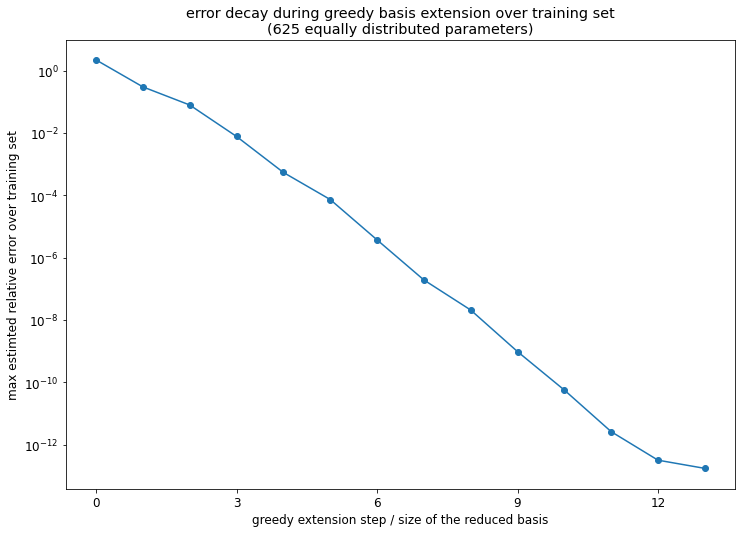

In [27]:
RB_rd = RB_greedy_data['rom']
RB_rd.disable_logging()

plt.plot(list(range(num_RB_greedy_extensions)) + [len(range(num_RB_greedy_extensions))],
         RB_greedy_errors,
         '-o')
plt.xticks(np.arange(0, num_RB_greedy_extensions + 1, 3))
plt.yscale('log')
plt.title('error decay during greedy basis extension over training set\n({} equally distributed parameters)'.format(len(training_set)))
plt.xlabel('greedy extension step / size of the reduced basis')
plt.ylabel('max estimted relative error over training set')

In [28]:
logger.info('plotting parameter values selected during the greedy ...')

fig = plt.figure()
ax = fig.gca(projection='3d')
x, y, f_of_x = compute_value_matrix(fom_objective_functional, XX, YY)
ax.plot_surface(x, y, f_of_x, cmap='Purples', linewidth=0, antialiased=False, alpha=0.5)
ax.view_init(elev=57.7597402597, azim=-59.6370967742)
ax.set_xlim3d([-0.10457963, 3.2961723])
ax.set_ylim3d([-0.10457963, 3.29617229])
ax.set_zlim3d([0.21921607, 4.42022848])

for mu in RB_greedy_mus:
    mu = mu.to_numpy()
    addplot_xy_point_as_bar(ax, mu[0], mu[1])

logger.info('... done')

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f813c0214d0> (for post_execute):


KeyboardInterrupt: 

In [29]:
logger.info('minimizing reduced quantity of interest:')

def rom_objective_functional(mu):
    return RB_rd.output(mu).to_numpy()

RB_minimization_data = {'num_evals': 0,
                        'evaluations' : [],
                        'evaluation_points': []}

tic = time.time()
result = minimize(partial(record_results, rom_objective_functional, RB_minimization_data),
                  initial_guess.to_numpy(),
                  method='L-BFGS-B', jac=False,
                  bounds=(ranges, ranges),
                  options={'ftol': 1e-10})
logger.info('this took {:.5f} seconds'.format(time.time()-tic))

report(result, RB_minimization_data)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

...........................

# using a gradient in fom

In [30]:
from pdeopt_model import LinearPdeoptStationaryModel

opt_fom = LinearPdeoptStationaryModel(fom)

In [31]:
print(opt_fom.output_functional_gradient(initial_guess, adjoint_approach=True))
print(opt_fom.output_functional_gradient(initial_guess, adjoint_approach=False))

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

[-1.31044258 -0.61760106]
[-1.31044258 -0.61760106]


In [33]:
logger.info('minimizing with fom and gradient information:')

def fom_gradient_of_functional(mu):
    return opt_fom.output_functional_gradient(opt_fom.parameters.parse(mu))
            

RB_minimization_data = {'num_evals': 0,
                        'evaluations' : [],
                        'evaluation_points': []}
tic = time.time()
result = minimize(partial(record_results, fom_objective_functional, RB_minimization_data),
                  initial_guess.to_numpy(),
                  method='L-BFGS-B', 
                  jac=fom_gradient_of_functional,
                  bounds=(ranges, ranges),
                  options={'ftol': 1e-10})
logger.info('this took {:.5f} seconds'.format(time.time()-tic))
report(result, RB_minimization_data)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

.........

In [34]:
opt_rom = LinearPdeoptStationaryModel(RB_rd)

In [35]:
print(opt_rom.output_functional_gradient(initial_guess, adjoint_approach=True))
print(opt_fom.output_functional_gradient(initial_guess, adjoint_approach=False))

[-1.31044258 -0.61760106]
[-1.31044258 -0.61760106]


In [36]:
logger.info('minimizing with rom and gradient information:')

def rom_gradient_of_functional(mu):
    return opt_rom.output_functional_gradient(opt_rom.parameters.parse(mu))
            

RB_minimization_data = {'num_evals': 0,
                        'evaluations' : [],
                        'evaluation_points': []}
tic = time.time()
result = minimize(partial(record_results, rom_objective_functional, RB_minimization_data),
                  initial_guess.to_numpy(),
                  method='L-BFGS-B', 
                  jac=rom_gradient_of_functional,
                  bounds=(ranges, ranges),
                  options={'ftol': 1e-10})
logger.info('this took {:.5f} seconds'.format(time.time()-tic))
report(result, RB_minimization_data)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

.........

# An RB space with dual information

In [38]:
logger.info('reducing with dual extended RB ...')
logger.info('')

from pdeopt_greedy import pdeopt_greedy
from pdeopt_reductor import LinearPdeoptStationaryCoerciveRBReductor

# TODO: min-theta approach
# def coercivity_estimator(mu):
#    return 1./np.sqrt(alpha(grid_and_problem_data['lambda']['coefficients'], mu, mu_bar))


pdeopt_reductor = LinearPdeoptStationaryCoerciveRBReductor(
    opt_fom, product=opt_fom.h1_0_semi_product)

pdeopt_greedy_data = pdeopt_greedy(opt_fom, pdeopt_reductor, training_set)

num_RB_greedy_extensions = RB_greedy_data['extensions']
RB_greedy_mus, RB_greedy_errors = RB_greedy_data['max_err_mus'], RB_greedy_data['max_errs']

logger.info('RB system is of size {}x{}'.format(num_RB_greedy_extensions, num_RB_greedy_extensions))
logger.info('maximum estimated model reduction error over training set: {}'.format(RB_greedy_errors[-1]))

logger.info('')
logger.info('... done')

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

My basis size is 1
My basis size is 2
My basis size is 3
My basis size is 4
My basis size is 5
My basis size is 6
My basis size is 7
My basis size is 8
My basis size is 9
My basis size is 10
My basis size is 11
My basis size is 12
My basis size is 13
My basis size is 13


# Enriching along the way

In [43]:
pdeopt_reductor = LinearPdeoptStationaryCoerciveRBReductor(
    opt_fom, product=opt_fom.h1_0_semi_product)

#pdeopt_reductor.extend_basis(initial_guess)
#opt_rom = pdeopt_reductor.reduce()

In [44]:
def record_results_and_enrich(function, data, mu):
    print('.', end='')
    try:
        pdeopt_reductor.extend_basis(mu)
    except:
        logger.info('Extension failed')
    opt_rom = pdeopt_reductor.reduce()
    QoI = function(mu)
    data['num_evals'] += 1
    # we need to make sure to copy the data, since the added mu will be changed inplace by minimize afterwards
    data['evaluation_points'].append([fom.parameters.parse(mu)['diffusion'][:][0], 
                                      fom.parameters.parse(mu)['diffusion'][:][1]])
    data['evaluations'].append(QoI[0])
    return QoI

def rom_objective_functional(mu):
    return opt_rom.output(mu).to_numpy()

def rom_gradient_of_functional(mu):
    return opt_rom.output_functional_gradient(opt_rom.parameters.parse(mu))

def report(result, data):
    if (result.status != 0):
        logger.info(' failed!')
    else:
        logger.info(' succeded!')
        logger.info('  mu_min:    {}'.format(fom.parameters.parse(result.x)))
        logger.info('  QoI(mu_min): {}'.format(result.fun[0]))
        logger.info('  num iterations:     {}'.format(result.nit))
        logger.info('  num function calls: {}'.format(data['num_evals']))

In [45]:
tic = time.time()
result = minimize(partial(record_results_and_enrich, rom_objective_functional, reference_minimization_data),
                  initial_guess.to_numpy(),
                  method='L-BFGS-B', jac=rom_gradient_of_functional,
                  bounds=(ranges, ranges),
                  options={'ftol': 1e-10})
logger.info('this took {:.5f} seconds'.format(time.time()-tic))

.

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

My basis size is 1
.My basis size is 2
.My basis size is 3
.My basis size is 4
.My basis size is 5
.My basis size is 6
.My basis size is 7
.My basis size is 8
.My basis size is 8


In [42]:
report(result, RB_minimization_data)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…